In [3]:
import networkx as nx
import json

#Data visualization
import seaborn as sns
import matplotlib as mpl

#Helper lib
import pandas as pd
import numpy as np
import random
import json

# Embedding libraries
from karateclub.utils.walker import RandomWalker
from karateclub import DeepWalk
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

#Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

#Matrix decomposition
from sklearn.decomposition import PCA



In [17]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Classifying Facebook pages using DeepWalk

## Introduction

### Karate Club Example
We are going to use famous Zachary's karate club dataset which comes with `NetworkX` package and `karateclub`'s implementation of the DeepWalk algorithm. Each student in the graph belongs to 1 of the 2 karate clubs - Officer or Mr. Hi. 

In [118]:
G = nx.karate_club_graph()  # load data

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

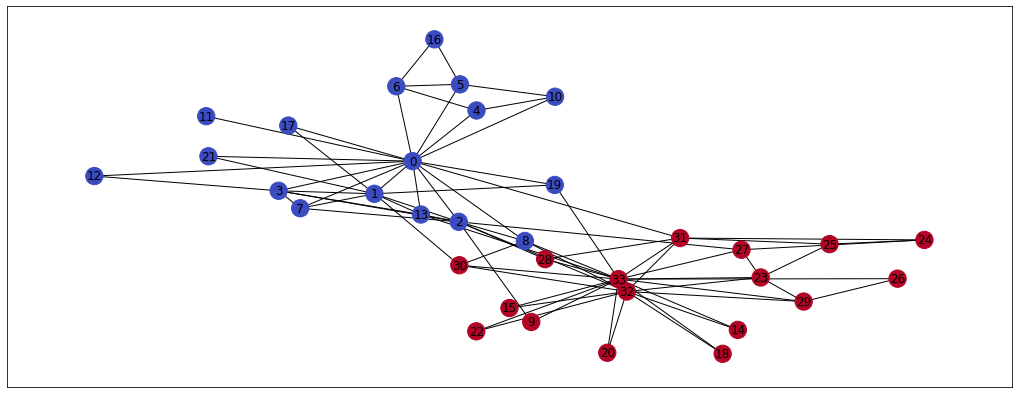

In [119]:
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

As you can see, members of the karate clubs talk mainly to their club members. This information could be very valuable for e.g. classification or community detection tasks and we can represent it using the node embeddings.

In [114]:
model = DeepWalk(dimensions=124)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


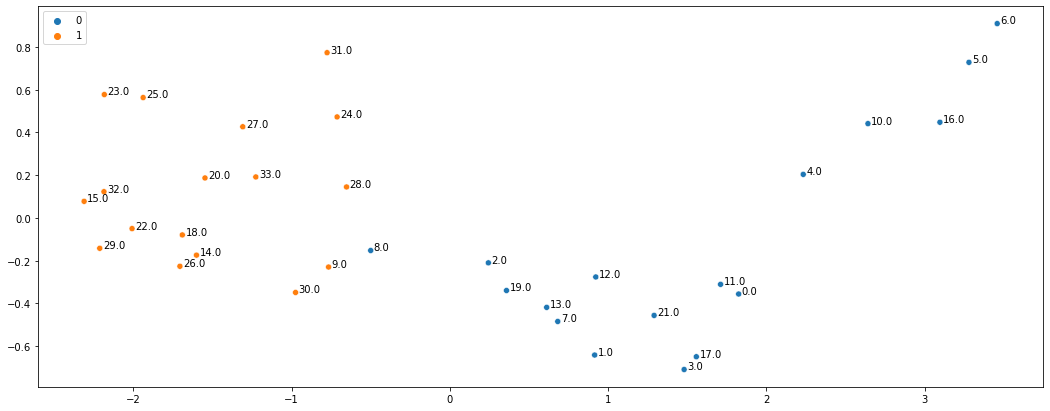

In [115]:
twoDim = PCA().fit_transform(embedding)

plot = sns.scatterplot(x = twoDim[:, 0], y = twoDim[:, 1], hue = clubs)
df = pd.DataFrame({'x': twoDim[:, 0], 'y': twoDim[:, 1], 'val': G.nodes})
for i, point in df.iterrows():
    plot.text(point['x']+.02, point['y'], str(point['val']))

In [49]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)

In [45]:
model = Word2Vec(walker.walks, hs=1, sg = 1,vector_size=128, window=5, min_count=1, workers=4)

In [46]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


The embeddings are trained, so now we could them for a supervised model or find clusters. Let's move on to an actual classification task

## Facebook Data

Facebook data can be downloaded from https://snap.stanford.edu/data/facebook-large-page-page-network.html

In [10]:
edges_path = 'data/facebook_edges.csv'
targets_path = 'data/facebook_target.csv'
features_path = 'data/facebook_features.json'

In [14]:
# Read the data
edges = pd.read_csv(edges_path)
targets = pd.read_csv(targets_path)
targets.index = targets.id
with open(features_path) as json_data:
    features = json.load(json_data)


With data read in, we can build a graph now and generate the embeddings

### DeepWalk on Facebook Graph

In [15]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

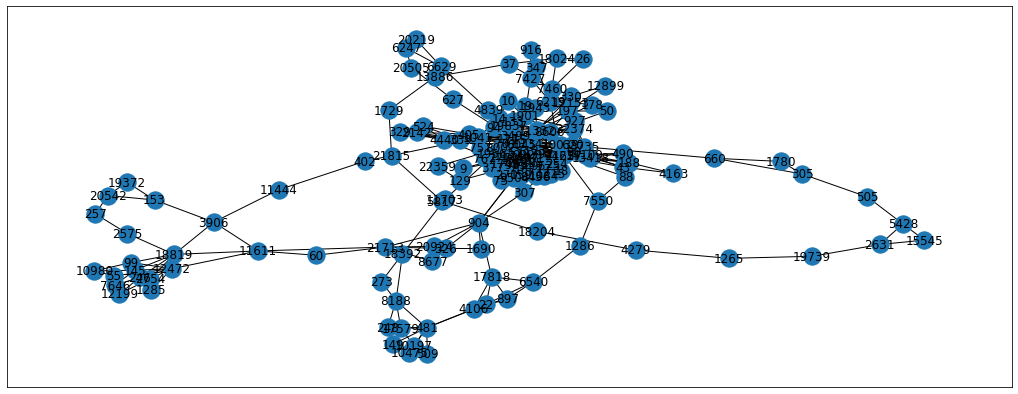

In [18]:
# Display a subgraph of 150 nodes related to Justin Trudeau.
justinTrudeauId = 11611
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, justinTrudeauId))[:150] 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos)

In [63]:
# Perform random walks and then train the Word2Vec model.
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)
model = Word2Vec(walker.walks, hs=1, sg = 1, vector_size=128, window=10, min_count=1, workers=4)
model.wv.save_word2vec_format('facebook.bin', binary=True)

In [20]:
# Load the previously trained model
model = KeyedVectors.load_word2vec_format('models/facebook.bin', binary=True)

Let's find Facebook pages that are similar to Statistics Canada (ID: 12646)

In [21]:
statsCanId = '12646'
similarList =  model.most_similar(statsCanId)
targets.loc[[int(statsCanId)] + [int(i[0]) for i in similarList], :]

,id,facebook_id,page_name,page_type
id,,,,
12646,12646,125909694187216,Statistics Canada,government
8068,8068,181477762000062,Department of Justice Canada,government
3918,3918,209857686718,Healthy Canadians,government
9229,9229,502566449790031,Leaders Today,government
7648,7648,192657607776229,Clerk of the Privy Council,government
1368,1368,218581684934651,GovCan - Indigenous Peoples,government
20470,20470,401846167974,Transport and Infrastructure in Canada,government
11016,11016,318424514044,Environment and Natural Resources in Canada,government
22076,22076,461055440583693,Canada's 150th Anniversary of Confederation,government


How about Justin Trudeau? (ID: 11611)

In [22]:
justinTrudeauId = 11611
similarList =  model.most_similar(justinTrudeauId)
targets.loc[[justinTrudeauId] + [int(i[0]) for i in model.most_similar(similarList)], :]

,id,facebook_id,page_name,page_type
id,,,,
11611,11611,21751825648,Justin Trudeau,politician
7090,7090,188474554625330,Anne Minh Thu Quach,politician
18483,18483,195399673828162,Hoang Mai,politician
2089,2089,7711496179,Irene Mathyssen,politician
18353,18353,35693908458,Malcolm Allen,politician
20522,20522,273781809343070,Jasbir Sandhu,politician
302,302,113413235475306,Murray Rankin,politician
3993,3993,149331805154700,Tom Mulcair,politician
13750,13750,186856648056251,Niki Ashton,politician


It seems like nodes are neighboring very related Facebook pages and that it's working. We can now use them as a classifier for machine learning. We're going to see if we can predict the type of page (government, tvshow, company, etc) given the graph embedding.

In [23]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.__getitem__(str(i)))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))

0.9341344014241211


As you can see, the performance is really good with F1 score of approximately 0.93.